In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [2]:
qc = QuantumCircuit(2, 2)

print("Quantum Circuit created:")
print(qc)

Quantum Circuit created:
     
q_0: 
     
q_1: 
     
c: 2/
     


In [3]:
def entangling_operator(qc, gamma=np.pi/2):
    qc.cx(0, 1)
    qc.rz(gamma, 1)
    qc.cx(0, 1)
    
def disentangling_operator(qc, gamma=np.pi/2):
    qc.cx(0, 1)
    qc.rz(-gamma, 1)
    qc.cx(0, 1)
    
# Classical strategies
def cooperate_strategy():
    qc = QuantumCircuit(1)
    return qc

def defect_strategy():
    qc = QuantumCircuit(1)
    qc.x(0)
    return qc

# Quantum strategy
def quantum_strategy():
    qc = QuantumCircuit(1)
    qc.z(0)
    qc.s(0)
    return qc

In [4]:
def quantum_prisoner_dilemma(strategy_A, strategy_B, gamma=np.pi/2):
    qc = QuantumCircuit(2, 2)

    # Start in |00>
    
    # Entangle
    entangling_operator(qc, gamma)

    # Apply strategies
    qc.append(strategy_A, [0])
    qc.append(strategy_B, [1])

    # Disentangle
    disentangling_operator(qc, gamma)

    # Measure
    qc.measure([0,1], [0,1])

    return qc

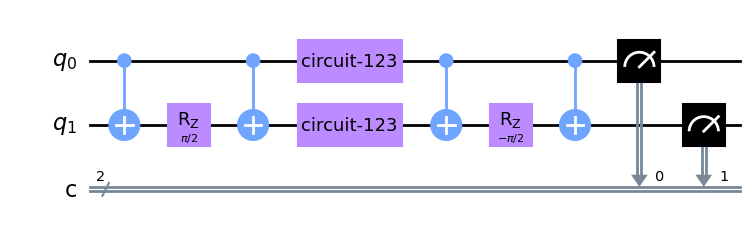

In [5]:
# Classical strategies
cooperate = QuantumCircuit(1)   # Identity = Cooperate

defect = QuantumCircuit(1)      # X = Defect
defect.x(0)

# Quantum strategy Q = iZ
quantum = QuantumCircuit(1)
quantum.z(0)
quantum.s(0) 

qc = quantum_prisoner_dilemma(quantum, quantum)
qc.draw('mpl')

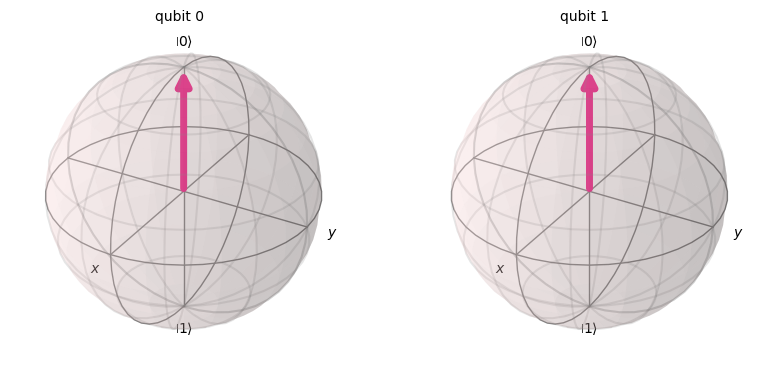

In [6]:
backend = Aer.get_backend('statevector_simulator')

qc_state = qc.remove_final_measurements(inplace=False)

job = execute(qc_state, backend)
state = job.result().get_statevector()
plot_bloch_multivector(state)

In [7]:
# Run Quantum Nash strategy (Q, Q)
qc_quantum = quantum_prisoner_dilemma(quantum, quantum)

backend = Aer.get_backend('qasm_simulator')
job = execute(qc_quantum, backend, shots=1024)
result = job.result()

# This is the missing line
counts = result.get_counts()

In [8]:
def quantum_payoff_matrix(counts):
    total = sum(counts.values())

    payoff_A = 0
    payoff_B = 0

    payoff_map = {
        '00': (3, 3),  # Cooperate, Cooperate
        '01': (0, 5),  # Cooperate, Defect
        '10': (5, 0),  # Defect, Cooperate
        '11': (1, 1)   # Defect, Defect
    }

    for outcome, count in counts.items():
        prob = count / total
        A, B = payoff_map[outcome]
        payoff_A += prob * A
        payoff_B += prob * B

    return payoff_A, payoff_B

In [9]:
def is_nash_equilibrium(current_payoff, deviated_payoff):
    return current_payoff >= deviated_payoff

In [10]:
# Run Quantum Nash strategy (Q, Q)
qc_quantum = quantum_prisoner_dilemma(quantum, quantum)

backend = Aer.get_backend('qasm_simulator')
job = execute(qc_quantum, backend, shots=1024)
counts_quantum = job.result().get_counts()

# Compute Quantum Nash payoffs
quantum_payoffs = quantum_payoff_matrix(counts_quantum)

print("Quantum Nash outcome distribution:", counts_quantum)
print("Quantum Nash payoffs:", quantum_payoffs)


Quantum Nash outcome distribution: {'00': 1024}
Quantum Nash payoffs: (3.0, 3.0)


In [11]:
# A defects, B plays quantum
qc_A_defect = quantum_prisoner_dilemma(defect, quantum)

# B defects, A plays quantum
qc_B_defect = quantum_prisoner_dilemma(quantum, defect)

jobA = execute(qc_A_defect, backend, shots=1024)
jobB = execute(qc_B_defect, backend, shots=1024)

counts_A_defect = jobA.result().get_counts()
counts_B_defect = jobB.result().get_counts()

payoff_A_defect, _ = quantum_payoff_matrix(counts_A_defect)
_, payoff_B_defect = quantum_payoff_matrix(counts_B_defect)


In [12]:
qc_A_defect = quantum_prisoner_dilemma(defect, quantum)
qc_B_defect = quantum_prisoner_dilemma(quantum, defect)

backend = Aer.get_backend('qasm_simulator')

jobA = execute(qc_A_defect, backend, shots=1024)
jobB = execute(qc_B_defect, backend, shots=1024)

counts_A_defect = jobA.result().get_counts()
counts_B_defect = jobB.result().get_counts()

payoff_A_defect, payoff_B_defect = quantum_payoff_matrix(counts_A_defect)
payoff_A_q, payoff_B_q = quantum_payoffs

print("\nNash Equilibrium Check:")
print("Quantum-Quantum Payoffs:", quantum_payoffs)
print("A defects payoff:", payoff_A_defect)
print("B defects payoff:", payoff_B_defect)

print("\nIs Quantum-Quantum Nash Equilibrium?")
print("Player A:", is_nash_equilibrium(payoff_A_q, payoff_A_defect))
print("Player B:", is_nash_equilibrium(payoff_B_q, payoff_B_defect))



Nash Equilibrium Check:
Quantum-Quantum Payoffs: (3.0, 3.0)
A defects payoff: 0.0
B defects payoff: 5.0

Is Quantum-Quantum Nash Equilibrium?
Player A: True
Player B: False


In [13]:
def classical_prisoners_dilemma(strategy_A, strategy_B):
    payoff_map = {
        ('C','C'): (3,3),
        ('C','D'): (0,5),
        ('D','C'): (5,0),
        ('D','D'): (1,1)
    }
    return payoff_map[(strategy_A, strategy_B)]

In [14]:
print("\nClassical Prisoner's Dilemma Payoffs:")
print("C,C:", classical_prisoners_dilemma('C','C'))
print("D,D:", classical_prisoners_dilemma('D','D'))

print("\nClassical Nash Equilibrium = (D, D)")


Classical Prisoner's Dilemma Payoffs:
C,C: (3, 3)
D,D: (1, 1)

Classical Nash Equilibrium = (D, D)


In [15]:
def classical_distribution(shots=1024):
    return {
        '00': 0,
        '01': 0,
        '10': 0,
        '11': shots   # (D,D)
    }

In [16]:
def normalize_counts(counts, shots=1024):
    return {
        '00': counts.get('00', 0),
        '01': counts.get('01', 0),
        '10': counts.get('10', 0),
        '11': counts.get('11', 0)
    }

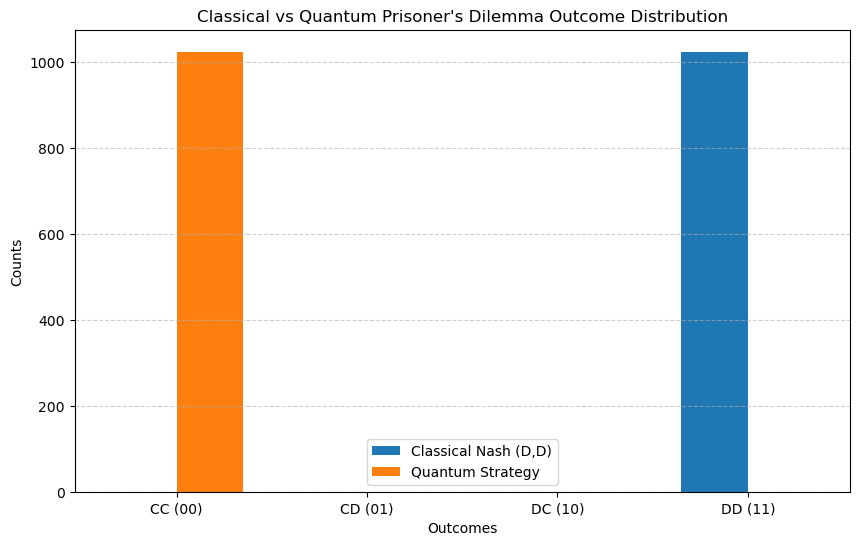

In [17]:
import matplotlib.pyplot as plt
import numpy as np

shots = 1024
classical_counts = classical_distribution(shots)
quantum_counts = normalize_counts(counts, shots)

labels = ['CC (00)', 'CD (01)', 'DC (10)', 'DD (11)']

classical_values = [classical_counts['00'], classical_counts['01'],
                    classical_counts['10'], classical_counts['11']]

quantum_values = [quantum_counts['00'], quantum_counts['01'],
                  quantum_counts['10'], quantum_counts['11']]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, classical_values, width, label='Classical Nash (D,D)')
plt.bar(x + width/2, quantum_values, width, label='Quantum Strategy')

plt.ylabel("Counts")
plt.xlabel("Outcomes")
plt.title("Classical vs Quantum Prisoner's Dilemma Outcome Distribution")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


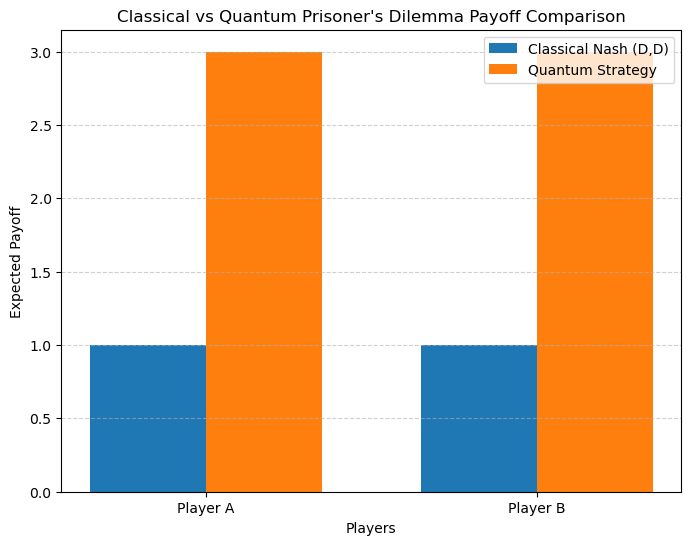

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Classical Nash payoff
classical_payoff_A = 1
classical_payoff_B = 1

# Quantum payoff from simulation
quantum_payoff_A, quantum_payoff_B = quantum_payoffs

labels = ['Player A', 'Player B']
classical_values = [classical_payoff_A, classical_payoff_B]
quantum_values = [quantum_payoff_A, quantum_payoff_B]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, classical_values, width, label='Classical Nash (D,D)')
plt.bar(x + width/2, quantum_values, width, label='Quantum Strategy')

plt.ylabel("Expected Payoff")
plt.xlabel("Players")
plt.title("Classical vs Quantum Prisoner's Dilemma Payoff Comparison")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
